# Lab 2: Mine Crafting

#### Maria Nolan

#### Teuben

#### PHYS265

#### April 6, 2025

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [49]:
# Constants
G = 6.6743E-11 # m^3 kg^-1 5^-2
g0 = 9.81 #m 5^-2
M_E = 5.972E24 # kg
M_M = 7.35E22 # kg
R_E = 6.3781E6 # m
R_M = 1.7381E6 # m
rot_e = 7.272E-5 # rot s^-1
depth = 4000 # m
m = 1 # kg

# Part 1: The Ideal Case

#### Question 1:

In [172]:
v_0 = 0 # m s^-1
d = 4000 # m
t = (-v_0-np.sqrt(v_0**2- 4*(0.5*-g0)*d) / (2*(0.5*-g0)))
print(f'The time it would take for the test mass to reach the bottom of the 4km shaft (assuming no drag) would be {t} seconds.')

The time it would take for the test mass to reach the bottom of the 4km shaft (assuming no drag) would be 28.55686245854129 seconds.


#### Question 2:

The equation
$\frac{d^2y}{dt^2} = -g - \alpha(\frac{dy}{dt})^\gamma$ can be reduced into a system of coupled first order differential equations by setting $v = \frac{dy}{dt}$.

The new coupled first order differential equations are:
$$
v = \frac{dy}{dt}
$$
$$
\frac{d^2y}{dt^2} = -g-\alpha v^\gamma
$$

#### Question 3:

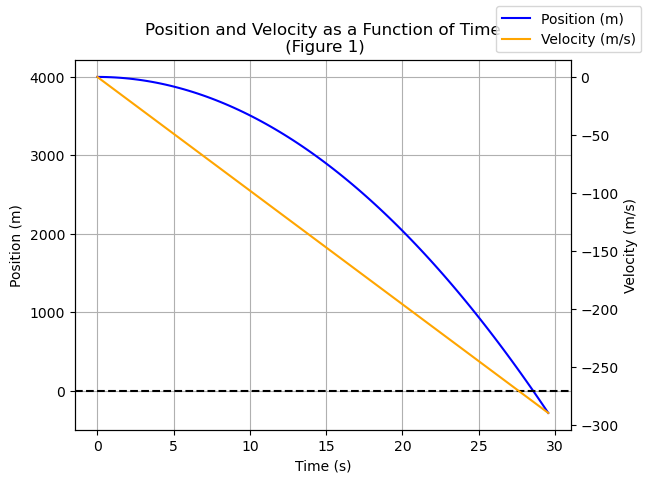

In [51]:
# constants
def free_fall(t, y):
    dydt = [y[1], -g0] # dy/dt = v, dvdt = -g
    return dydt

# initial conditions
y0 = [4000, 0] # initial position (4km) and velocity (0 m/s)
time_span = (0, np.sqrt(2 * y0[0] / g0) + 1) # estimated time span based on free-fall equation
t_eval = np.linspace(time_span[0], time_span[1], 100) # time points for evaluation

# solve ODE
sol = solve_ivp(free_fall, time_span,y0, t_eval=t_eval)

time = sol.t
pos = sol.y[0]
vel = sol.y[1]

# plot
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(time, pos, 'b-', label = 'Position (m)')
ax2.plot(time, vel, color='orange', linestyle='-', label="Velocity (m/s)")
ax.axhline(0, linestyle='--', color='k')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (m)")
ax2.set_ylabel("Velocity (m/s)")
ax.set_title("Position and Velocity as a Function of Time\n (Figure 1)")
fig.legend();
ax.grid()

#### Question 4:

In [183]:
def hit_ground(t,y):
    return y[0] # Event function to detect when position reaches zero

hit_ground.terminal = True # stop integration when event occurs
hit_ground.direction = -1 # detect only when approaching y = 0 from above

sol = solve_ivp(free_fall, time_span, y0, t_eval=t_eval, events=hit_ground)

if sol.t_events and sol.t_events[0].size > 0:
    time_hit_ground = sol.t_events[0][0]
else:
    time_hit_ground = None

# analytical calculation using t = sqrt(2h/g)
analytic_time = np.sqrt(2 * y0[0] / g0)

# print results
if time_hit_ground is not None:
    print(f'Numerical impact time: {time_hit_ground} s')
    print(f'Analytical impact time: {analytic_time} s')
    print(f'Difference: {abs(time_hit_ground - analytic_time)} s')
else:
    print("Error: No impact time detected. Consider adjusting the integration time span.")


Numerical impact time: 1265.768265985144 s
Analytical impact time: 1140.3184633063652 s
Difference: 125.44980267877872 s


# Part 2: Including Drag and a Variable $g$

Time to hit bottom: 28.558356860354444 seconds.


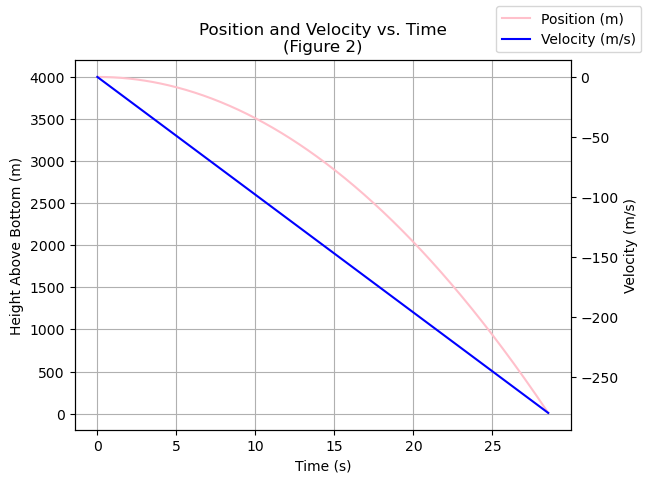

In [174]:
def grav(r):
    return g0 * (r / R_E)

def equations(t, state):
    y, v = state # Pos and Vel
    dydt = v
    dvdt = -grav(y) # acceleration due to gravity
    return [dydt, dvdt]

# initial conditions
r0 = R_E
v0 = 0

# Time span & t_eval
t_span = (0,50) # 50 s
t_eval = np.linspace(0,50,1000)

def event_bottom(t, state):
    return state[0] - (R_E - depth)
event_bottom.terminal = True
event_bottom.direction= -1
    
# solve ODE
sol = solve_ivp(equations, t_span, [r0, v0], t_eval = t_eval, events=event_bottom)

# extract results
time = sol.t
pos = sol.y[0] - (R_E - depth)
vel = sol.y[1]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(time, pos, label = "Position (m)", color="pink")
ax2.plot(time, vel, label = "Velocity (m/s)", color = "blue")
ax2.set_ylabel("Velocity (m/s)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Height Above Bottom (m)")
ax.set_title("Position and Velocity vs. Time\n(Figure 2)")
fig.legend()
ax.grid()
plt.tight_layout

fall_time = sol.t_events[0][0] if sol.t_events[0].size > 0 else None

print(f"Time to hit bottom: {fall_time} seconds.")

#### Question 2:

By incorporating a height-dependent $g(r) = g_o (\frac{r}{R_E})$, the fall time increases by $0.0015$ seconds. This is likely due to the fact that as the mass falls deeper into the mine, the gravitational acceleration decreases because $r$ is getting smaller. This leads to a slower acceleration compared to a constant $g$. Since the object is accelerating slower than it would under a constant gravity, it takes longer to reach the bottom.

#### Question 3:

Assume that $\rho = 1.225 \frac{kg}{m^s}$ at sea level and 15$\degree$C. Also assume a spherical shape with a radius $r = 0.1m$ for simplicity with a drag coefficient $C_d = 0.47$. According to Google, the terminal velocity is equal to $ v = 32.9 \frac{m}{s}$.

Calculated using: https://www.gigacalculator.com/calculators/terminal-velocity-calculator.php

Time to hit bottom: 161.430888423177 seconds.


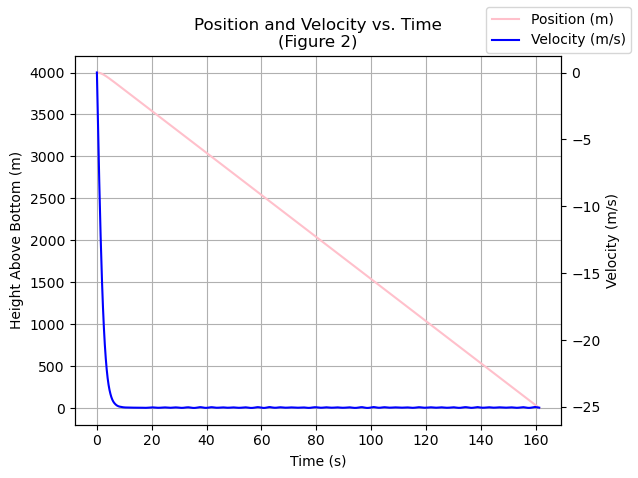

In [175]:
def grav(r):
    return g0 * (r / R_E)

def equations(t, state):
    y, v = state # Pos and Vel
    dydt = v
    dvdt = -grav(y) + (4**-3)*(np.abs(dydt)**2) # acceleration due to gravity
    return [dydt, dvdt]

# initial conditions
r0 = R_E
v0 = 0

# Time span & t_eval
t_span = (0,170) # 170 s
t_eval = np.linspace(0,170,1000)

def event_bottom(t, state):
    return state[0] - (R_E - depth)
event_bottom.terminal = True
event_bottom.direction= -1
    
# solve ODE
sol = solve_ivp(equations, t_span, [r0, v0], t_eval = t_eval, events=event_bottom)

# extract results
time = sol.t
pos = sol.y[0] - (R_E - depth)
vel = sol.y[1]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(time, pos, label = "Position (m)", color="pink")
ax2.plot(time, vel, label = "Velocity (m/s)", color = "blue")
ax2.set_ylabel("Velocity (m/s)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Height Above Bottom (m)")
ax.set_title("Position and Velocity vs. Time\n(Figure 2)")
fig.legend()
ax.grid()
plt.tight_layout()

fall_time = sol.t_events[0][0] if sol.t_events[0].size > 0 else None

print(f"Time to hit bottom: {fall_time} seconds.")

By including drag, the fall time increases drastically. The fall time (using g(r)) went from 28.5584 seconds to 161.4309 seconds, which is a huge difference in time. Drag increase fall time this drastically because drag acts against motion, reducing acceleration as velocity increases. Eventually, the object hits a terminal velocity (in this case, $-25 \frac{m}{s}$) and no longer accelerates significantly, therefore making the descent slower.

# Part 3: The Coriolis Force

#### Question 1:
We can derive the Coriolis acceleration from the Coriolis force equation:
$$
F_c = +2m (\vec{\Omega} \times \vec{v_y})
$$
and we get:
$$
a_c = -2(\Omega \times v)
$$
$$
a_{c_x} = +2\Omega v_y
$$
$$
a_{c_y} = -2\Omega v_x
$$
$$
a_{c_z} = 0
$$

In [190]:
alpha = 4**-3 # Change depending on if you want to turn drag on or off
def equations (t, state):
    x, vx, y, vy, z, vz = state

    # coriolis forces
    f_coriolis_x = 2*m*rot_e*vy
    f_coriolis_y = -2*m*rot_e*vx

    # gravity depends on depth
    g = g0*(R_E/(R_E+y))

    # speed for drag
    v = np.sqrt(vx**2 + vy**2 + vz**2)

    # drag accelerations
    drag_x = -alpha*v*vx/m
    drag_y = -alpha*v*vy/m

    # derivatives
    dxdt = vx
    dvxdt = f_coriolis_x / m + drag_x
    dydt = vy
    dvydt = -g + f_coriolis_y / m + drag_y
    dzdt = vz
    dvzdt = 0 # no vertical coriolis
    
    return [dxdt, dvxdt, dydt, dvydt, dzdt, dvzdt]

# initial conditions
initial_conditions = [0,0,0,0,0,0]

# Integration time
t_span = (0,1000)
t_eval = np.linspace(*t_span, 1000)

# solve ODE
sol = solve_ivp(equations, t_span, initial_conditions, t_eval=t_eval)

# extract results
x, vx, y, vy, z, vz = sol.y
t = sol.t

#### Question 2:

The mass hits the wall at t = 273.2732732732733 s, depth = -6804.936246757053 m.


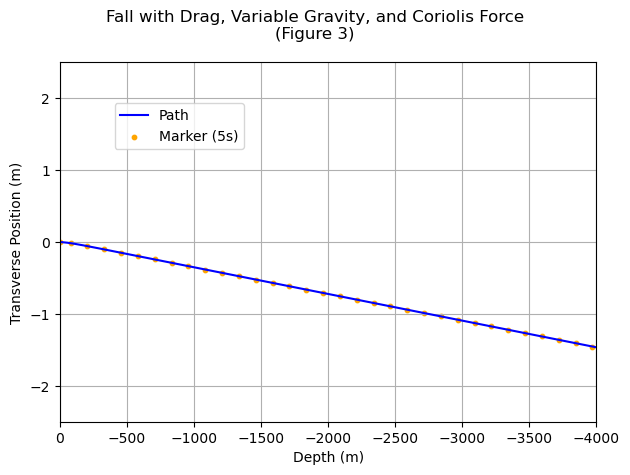

In [191]:
# Find points every N seconds
N = 5
marker_times = np.arange(0, t[-1], N)
marker_indices = [np.argmin(np.abs(t - mt)) for mt in marker_times]

# plot
fig, ax1 = plt.subplots()
ax1.plot(y, x, label="Path", color='blue')
ax1.scatter(y[marker_indices], x[marker_indices], color='orange', s=10, label='Marker (5s)')
ax1.set_ylabel("Transverse Position (m)")
ax1.set_xlabel("Depth (m)")

ax1.set_xlim(-4000,0)
ax1.set_ylim(-2.5,2.5)

ax1.invert_xaxis()

fig.suptitle("Fall with Drag, Variable Gravity, and Coriolis Force\n(Figure 3)")

ax1.grid()
plt.tight_layout()
fig.legend(loc=1, bbox_to_anchor=(0.4, 0.8))

# Shaft wall threshold
shaft_radius = 2.5  # meters

# Check when x exceeds the shaft boundary
hit_indices = np.where(np.abs(x) >= shaft_radius)[0]

if len(hit_indices) > 0:
    first_hit_index = hit_indices[0]
    hit_time = t[first_hit_index]
    hit_depth = y[first_hit_index]
    print(f"The mass hits the wall at t = {hit_time} s, depth = {hit_depth} m.")
else:
    print("The mass does not hit the wall within the simulation time.")

### Question 3:
If the mine shaft is 5m wide, and the test mass is dropped from the center, the test mass will not reach the bottom before it hits the wall. According to Figure 3, the test mass will hit the wall about 2.3 km down the mine shaft.

#### Question 4: 
Once drag is turned back on, the test mass ends up hitting the bottom of the mine shaft before hitting the wall, as shown in the updated version of Figure 3. This shows the massive impact that drag has on a falling object.

# Part 4: An Infinitely Deep Mine

#### Question 1:

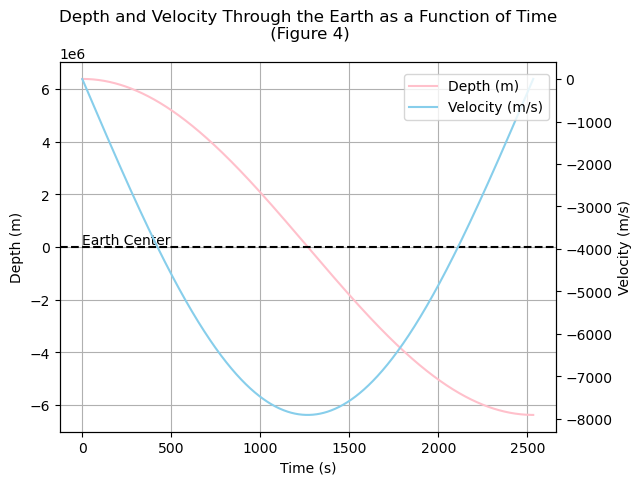

In [57]:
def free_fall(t,y):
    dydt = [y[1], -g0 * (y[0] / R_E)]
    return dydt

# initial conditions
y0 = [R_E, 0] # y[0]: positon from center, y[1]: velocity

T = np.pi * np.sqrt(R_E / g0)
time_span = (0, T) # estimated time span based on free-fall equation
t_eval = np.linspace(time_span[0], time_span[1], 1000) # time points for evaluation

# solve ODE
sol = solve_ivp(free_fall, time_span, y0, t_eval=t_eval)

time = sol.t
pos = sol.y[0] 
vel = sol.y[1]

# plot
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(time, pos, color="pink", label = 'Depth (m)')
ax.annotate("Earth Center", xy=(0,100000))
ax2.plot(time, vel, color='skyblue', linestyle='-', label="Velocity (m/s)")
ax.axhline(0, linestyle='--', color='k')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Depth (m)")
ax2.set_ylabel("Velocity (m/s)")
ax.set_title("Depth and Velocity Through the Earth as a Function of Time\n (Figure 4)")
fig.legend(bbox_to_anchor=(0.9, 0.87));
ax.grid()

0 on the y-axis represents the very center of the Earth. The depth begins at about $6 \times 10^6$ meters which represents the surface of one side of the Earth. The depth ends at about $-6 \times 10^6$ meters, which represents the surface on the other side of the Earth. By looking at the graph, we notice that it looks very different from Figure 1. This is because we have to make sure gravity is dependent on distance from the center of the Earth because right after the mass falls through the center, gravity appears to change direction. From $6 \times 10^6$ meters to 0 meters, the test mass is falling in the same direction that gravity is in. From 0 to $-6 \times 10^6$ meters, the test mass is opposing gravity, therefore slowing down.

#### Question 2:

In [176]:
v_max = np.min(vel)
crossing_time = T/2
print(f"The object will take {T} seconds to reach the other side of the Earth.\n\nAt {crossing_time} seconds, the mass reaches the center of the Earth at a max speed of {v_max} meters per second.")

The object will take 2533.1507223454087 seconds to reach the other side of the Earth.

At 1266.5753611727043 seconds, the mass reaches the center of the Earth at a max speed of -25.079628790225822 meters per second.


#### Question 3: 

In [177]:
v_orbit = np.sqrt(G * M_E / R_E)
T_orbit = 2 * np.pi * R_E / v_orbit

print("v_orbit:", v_orbit, "m/s")
print("\n\nT_orbit:", T_orbit, 's')

v_orbit: 7909.680821529872 m/s


T_orbit: 5060.908840098885 s


The "crossing-time" is approximately 0.5 times the period of a full orbit. This is because the test mass is making a one-way trip from one side of the Earth to the other, while the orbital period represents a round-trip, beginning and ending at the same spot. Therefore, it makes sense for the "crossing-time" to be approximately 0.5 times the orbital period.

# Part 5: A Non-Uniform Earth

#### Question 1:

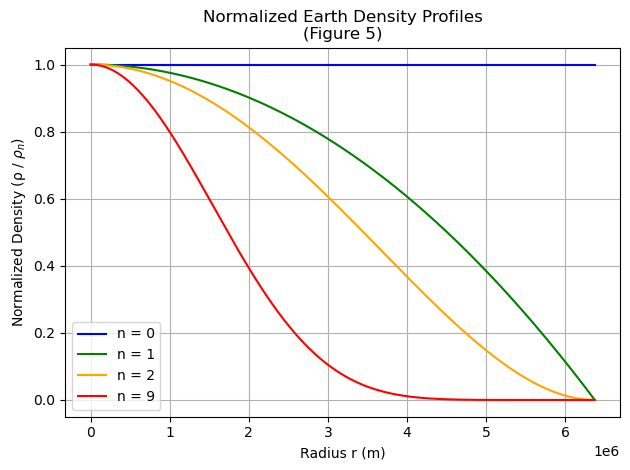

In [118]:
# Density function
def rho(r, n): 
    return (1 - (r / R_E)**2)**n

# Values of n to plot
n_values = [0, 1, 2, 9]
colors = ['blue', 'green', 'orange', 'red']
r_values = np.linspace(0, R_E, 500)
# Plot
fig, ax = plt.subplots()
for n, color in zip(n_values, colors):
    ax.plot(r_values, rho(r_values, n), label = f'n = {n}', color=color)

ax.set_xlabel('Radius r (m)')
ax.set_ylabel('Normalized Density (ρ / $ρ_n$)')
ax.set_title('Normalized Earth Density Profiles\n(Figure 5)')
ax.legend()
ax.grid()
fig.tight_layout()

#### Question 2:

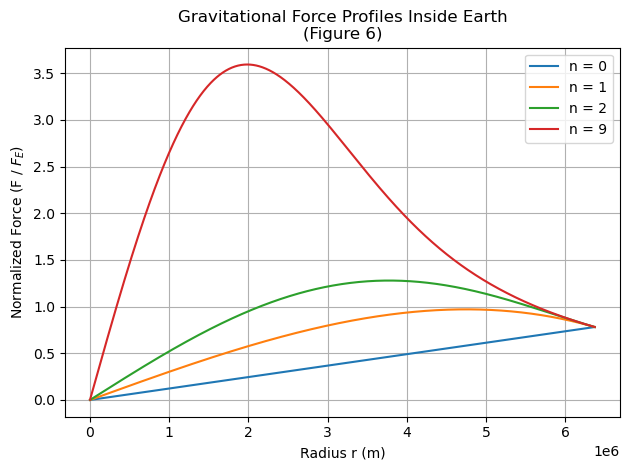

In [128]:
# density function
def rho(r, n, rho_n):
    return rho_n * (1 - (r / R_E)**2)**n

# Enclosed Mass Function
def enclosed_mass(r, n, rho_n):
    integrand = lambda r_prime: density(r_prime, n, rho_n) * r_prime**2
    mass, _ = quad(integrand, 0, r)
    return mass

# Compute rho_n to normalize tot mass to 1
def compute_g_force(r, n, rho_n):
    M_enc = enclosed_mass(r, n, rho_n)
    force = G * M_enc / r**2
    return force

# Compute enclosed mass as a function of r
def compute_rho_n(n):
    mass_integrand = lambda r: density(r, n, 1) * r**2
    mass_integral, _ = quad(mass_integrand, 0, R_E)
    rho_n = M_E / (4 * np.pi * mass_integral)
    return rho_n

# Plot force profile
n_values = [0,1,2,9]
r_values = np.linspace(1e3, R_E, 1000)

fig, ax = plt.subplots()
for n in n_values:
    rho_n = compute_rho_n(n)
    forces = [compute_g_force(r, n, rho_n) for r in r_values]
    ax.plot(r_values, forces, label=f'n = {n}')
    

ax.set_xlabel("Radius r (m)")
ax.set_ylabel("Normalized Force (F / $F_E$)")
ax.set_title("Gravitational Force Profiles Inside Earth\n(Figure 6)")
ax.grid()
ax.legend()
fig.tight_layout()

#### Question 3:

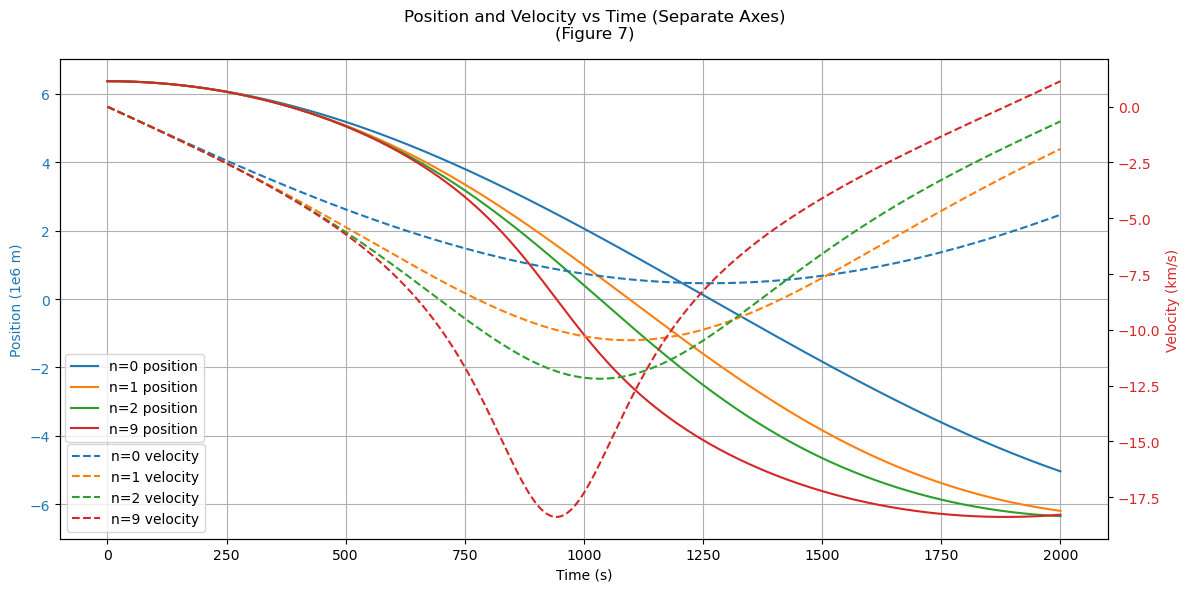

In [171]:
import pandas as pd

# Constants
G = 6.67430e-11  # m^3 kg^-1 s^-2
R_earth = 6.371e6  # meters
M_earth = 5.972e24  # kg
n_values = [0, 1, 2, 9]

# Density profile and normalization
def density_profile(r, n, rho_n):
    return rho_n * (1 - (r**2 / R_earth**2))**n

def mass_integral(n):
    integrand = lambda r: (1 - (r**2 / R_earth**2))**n * r**2
    integral, _ = quad(integrand, 0, R_earth)
    rho_n = M_earth / (4 * np.pi * integral)
    return rho_n

rho_n_dict = {n: mass_integral(n) for n in n_values}

# Enclosed mass M(r)
def enclosed_mass(r, n, rho_n):
    integrand = lambda s: density_profile(s, n, rho_n) * s**2
    integral, _ = quad(integrand, 0, r)
    return 4 * np.pi * integral

# Acceleration at radius r
def acceleration(r, n, rho_n):
    if r == 0:
        return 0
    M_r = enclosed_mass(r, n, rho_n)
    return -G * M_r / r**2

# Simulate motion through Earth
def simulate_fall(n, rho_n):
    def ode(t, y):
        r, v = y
        a = acceleration(r, n, rho_n)
        return [v, a]

    r0 = R_earth
    v0 = 0
    y0 = [r0, v0]
    t_span = (0, 2000)
    
    sol = solve_ivp(ode, t_span, y0, dense_output=True, max_step=1, rtol=1e-8, atol=1e-10,
                    events=lambda t, y: y[0])  # stop when r = 0
    return sol

# Run simulations
results = {n: simulate_fall(n, rho_n_dict[n]) for n in n_values}

# Plot position and velocity with separate y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left axis for position
for n in n_values:
    sol = results[n]
    t = sol.t
    r = sol.y[0]
    ax1.plot(t, r / 1e6, label=f'n={n} position', linestyle='-')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (1e6 m)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis for velocity
ax2 = ax1.twinx()
for n in n_values:
    sol = results[n]
    t = sol.t
    v = sol.y[1]
    ax2.plot(t, v / 1e3, label=f'n={n} velocity', linestyle='--')
ax2.set_ylabel('Velocity (km/s)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Position and Velocity vs Time (Separate Axes)\n(Figure 7)')
fig.tight_layout()
ax1.grid(True)
ax1.legend(bbox_to_anchor=(0.144,0.4))
ax2.legend()
plt.show()




#### Question 4:

In [137]:
# Print summary of fall times and speeds
summary = [(n, results[n].t_events[0][0], abs(results[n].y_events[0][0][1])) for n in n_values]
df_summary = pd.DataFrame(summary, columns=["n", "Time to center (s)", "Speed at center (m/s)"])
print(df_summary)


   n  Time to center (s)  Speed at center (m/s)
0  0         1265.227210            7909.680822
1  1         1094.682565           10463.524202
2  2         1033.347784           12189.636804
3  9          942.202073           18380.907287


# Part 6: A Lunar Mine Shaft

#### Question 1: 

In [180]:
# Time to fall to center (quarter of SHM period)
t_center_moon = (np.pi / 2) * np.sqrt(R_M**3 / (G * M_M))

# Output result
print(f"Time to fall to the center of the Moon: {t_center_moon} seconds")
print(f"≈ {t_center_moon / 60} minutes")

Time to fall to the center of the Moon: 1625.1201867414668 seconds
≈ 27.085336445691112 minutes


#### Question 2: 

In [181]:
def density(M, R):
    return M / ((4/3) * np.pi * R**3)

# Compute densities
rho_earth = density(M_E, R_E)
rho_moon = density(M_M, R_M)

# Compare
ratio = rho_moon / rho_earth

# Output
print(f"Earth density: {rho_earth} kg/m³")
print(f"Moon density: {rho_moon} kg/m³")
print(f"Density ratio (Moon / Earth): {ratio}")

Earth density: 5513.258738589093 kg/m³
Moon density: 3341.7538038703183 kg/m³
Density ratio (Moon / Earth): 0.6061304143918179


#### Question 3:

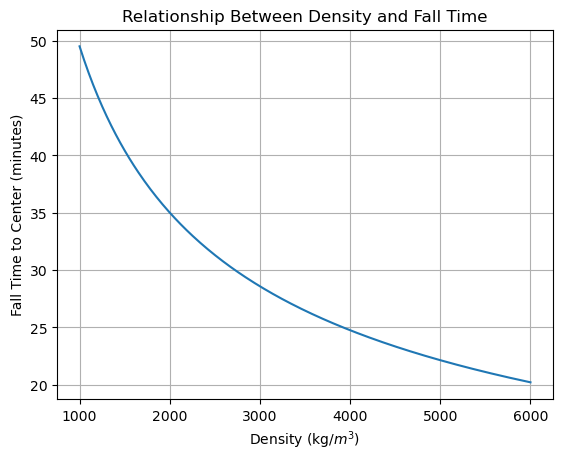

In [170]:
# Fall time as a function of density (homogeneous sphere)
def fall_time(rho):
    return (np.pi / 2) * np.sqrt(3 / (4 * np.pi * G * rho))

# Generate a range of densities (1000 to 6000 kg/m³)
densities = np.linspace(1000, 6000, 300)
fall_times = fall_time(densities) / 60  # convert to minutes

fig, ax = plt.subplots()
ax.plot(densities, fall_times, label='Fall Time vs Density')
ax.set_xlabel("Density (kg/$m^3$)")
ax.set_ylabel("Fall Time to Center (minutes)")
ax.set_title("Relationship Between Density and Fall Time")
ax.grid()

This plot clearly shows an inverse square-root plot. As density increases, fall time to the center drops rapidly at first, then levels off.